In [30]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Skipping, found downloaded files in "./animal-faces" (use force=True to force download)


In [31]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import torch

# GPU?

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


# Reading Data Paths

In [33]:
os.listdir("/content/animal-faces/afhq")

['val', 'train']

In [34]:
base_dir = '/content/animal-faces/afhq'
image_path = []
labels = []

for i in os.listdir(base_dir):  # train,val
    label_path = os.path.join(base_dir,i)

    for label in os.listdir(label_path): # cat,dog,wild
        img_path = os.path.join(label_path,label)

        for image in os.listdir(img_path): #loop through each individual image
            image_path.append(os.path.join(img_path,image)) # path of each image
            labels.append(label) # label of each image (label = folder name(cat,dog,wild))

# create a new dataframe

df = pd.DataFrame(zip(image_path,labels),columns=['image_path','labels']) # zip  combine two lists into pairs (img_path-label)=tuple pair
df.head()

# if zip is not used then a dataframe with 2 rows will be formed :  (or a value error will be raised)
# 1 - all the img paths
# 2 - all the labels
# THIS WILL NOT BE THE CORRECT STRUCTURE FOR THE DATAFRAME

,image_path,labels
0,/content/animal-faces/afhq/val/wild/pixabay_wi...,wild
1,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
2,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
3,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
4,/content/animal-faces/afhq/val/wild/flickr_wil...,wild


# Splitting the data

In [35]:
train = df.sample(frac=0.7,random_state=8) # 70%
temp = df.drop(train.index) # Create testing by removing the 70% of the train data

val = temp.sample(frac=0.5,random_state=8) # 15%
test = temp.drop(val.index)  # 15%

In [36]:
train.shape,val.shape,test.shape

((11291, 2), (2420, 2), (2419, 2))

# Preprocessing

In [37]:
from sklearn.preprocessing import LabelEncoder #encode the classes from strings to numbers
import torchvision.transforms as transforms #used to modify and preprocess all the images

In [38]:
label_encoder = LabelEncoder()
label_encoder.fit(df['labels'])

LabelEncoder()

In [39]:
transform = transforms.Compose([transforms.Resize((128,128)),
                                transforms.ToTensor(), # Converts PIL img or numpy array to pytorch tensor(obj) and Also scales pixel values from [0, 255] to [0.0, 1.0]
                                transforms.ConvertImageDtype(torch.float32) # Ensures the image tensor is in float32 format.
                                ])

# Custom Datast

In [40]:
from torch.utils.data import Dataset, DataLoader

In [41]:
class CustomImageDataset(Dataset):
  def __init__(self,df,transform=None):
    self.df = df
    self.transform = transform
    self.lab = label_encoder.transform(df['labels'])  # label_encoder = global var and used to transform labels to numbers
    self.labels = torch.tensor(self.lab)    # numpy to pytorch object(dtype=int64)

  def __len__(self):
      return self.df.shape[0]  # no of rows of df = no.of sample/imgs

  def __getitem__(self,idx): # return 1 complte row : img+label
      img_path = self.df.iloc[idx,0] # 0 is the index of img path col
      label = self.labels[idx]  # tensor obj
      img = Image.open(img_path).convert('RGB')  # opens the img in RGB mode

      if self.transform:  # if user provided a transform
        img = self.transform(img)  # perform the transformations on the image

      return img,label

Creating Dataset Objects

In [42]:
train_dataset = CustomImageDataset(train,transform=transform)
val_dataset = CustomImageDataset(val,transform=transform)
test_dataset = CustomImageDataset(test,transform=transform)

In [43]:
# using some dataset class functions
train_dataset.__len__()

11291

In [44]:
# knowing our label encoding
label_encoder.inverse_transform([0,1,2])

array(['cat', 'dog', 'wild'], dtype=object)

Visualizing the dataset


In [45]:
import matplotlib.pyplot as plt

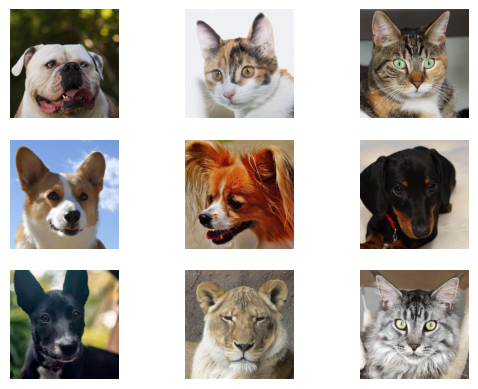

In [46]:
fig,axes = plt.subplots(3,3)
for i in range(3):
  for j in range(3):
    image = Image.open(df.sample(n=1)['image_path'].iloc[0]).convert('RGB')
    axes[i,j].imshow(image)
    axes[i,j].axis('off')
plt.show()

# DataLoader

In [47]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle =True)

# Model

In [48]:
from torch import nn
from torch.optim import Adam

In [49]:
LR = 1e-4
BATCH_SIZE = 32
EPOCHS = 10

In [50]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3,32,kernel_size=3,padding=1) # inputs 3 chanels RGB = (3x128x128)
    self.conv2 = nn.Conv2d(32,64,kernel_size=3,padding=1)
    self.conv3 = nn.Conv2d(64,128,kernel_size=3,padding=1)
    self.pooling = nn.MaxPool2d(2,2)
    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()
    self.linear = nn.Linear((128*16*16),128)
    self.output = nn.Linear(128,3)

  def forward(self,x):
    x = self.conv1(x) # (32,128,128)
    x = self.pooling(x)# (32, 64, 64)
    x = self.relu(x)
    x = self.conv2(x) #  (64, 64, 64)
    x = self.pooling(x)#  (64, 32, 32)
    x = self.relu(x)
    x = self.conv3(x) # (128, 32, 32)
    x = self.pooling(x) # (128, 16, 16)
    x = self.relu(x)
    x = self.flatten(x)
    x = self.linear(x)
    x = self.output(x)

    return x



In [51]:
model = Net().to(device)

# Model Summary

In [52]:
from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

# Loss and Optimizer

In [53]:
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(model.parameters(), lr=LR) # Adam optimizer

# Training

In [55]:
for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  for inputs,labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    pred = model(inputs)
    train_loss = criterion(pred,labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(pred,axis=1)==labels).sum().item()
    total_acc_train += train_acc

    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for inputs,labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      pred = model(inputs)
      val_loss = criterion(pred,labels)
      total_loss_val += val_loss.item()
      val_acc = (torch.argmax(pred,axis=1)==labels).sum().item()
      total_acc_val += val_acc

  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
  print("="*25)

Epoch 1/10, Train Loss: 0.8656 Train Accuracy 91.0017
              Validation Loss: 0.1425 Validation Accuracy: 93.2231
Epoch 2/10, Train Loss: 0.5958 Train Accuracy 93.7295
              Validation Loss: 0.1178 Validation Accuracy: 93.9256
Epoch 3/10, Train Loss: 0.4483 Train Accuracy 95.5363
              Validation Loss: 0.1089 Validation Accuracy: 94.7107
Epoch 4/10, Train Loss: 0.344 Train Accuracy 96.5016
              Validation Loss: 0.1276 Validation Accuracy: 93.9669
Epoch 5/10, Train Loss: 0.2874 Train Accuracy 97.1393
              Validation Loss: 0.0898 Validation Accuracy: 95.5372
Epoch 6/10, Train Loss: 0.2129 Train Accuracy 97.901
              Validation Loss: 0.101 Validation Accuracy: 95.5372
Epoch 7/10, Train Loss: 0.168 Train Accuracy 98.3615
              Validation Loss: 0.0888 Validation Accuracy: 96.157
Epoch 8/10, Train Loss: 0.1257 Train Accuracy 98.7512
              Validation Loss: 0.0864 Validation Accuracy: 96.0744
Epoch 9/10, Train Loss: 0.0907 Train 

# Testing

In [58]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")


Accuracy Score is: 96.3621 and Loss is 0.0088


# Inference/Prediction



1.  read image
2.  Transform using transform object
3.  predict through the model
4. inverse transform by label encoder






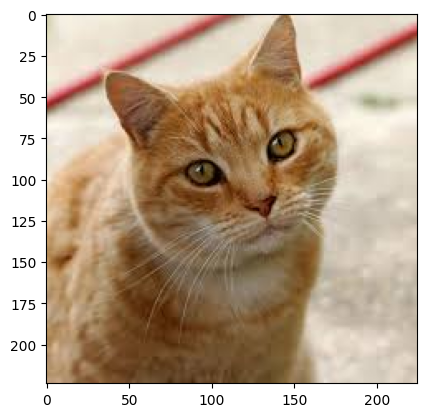


Prediction: 



array(['cat'], dtype=object)

In [61]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

## Visualize the image
image = Image.open("/content/images.jfif")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("/content/images.jfif")